Day 3/4 - Today, we work on Milstein Scheme for the GBM (Geometric Brownian Motion), its almost similar but we'll compare the 2 vectorized functions to see differences, since this one is better in term of accuracy. We also did (on day 4) error comparaisons for a high number of paths, and failed to get the expected result (last cell explains)

Euler-Maruyama simulation :
Milstein simulation :


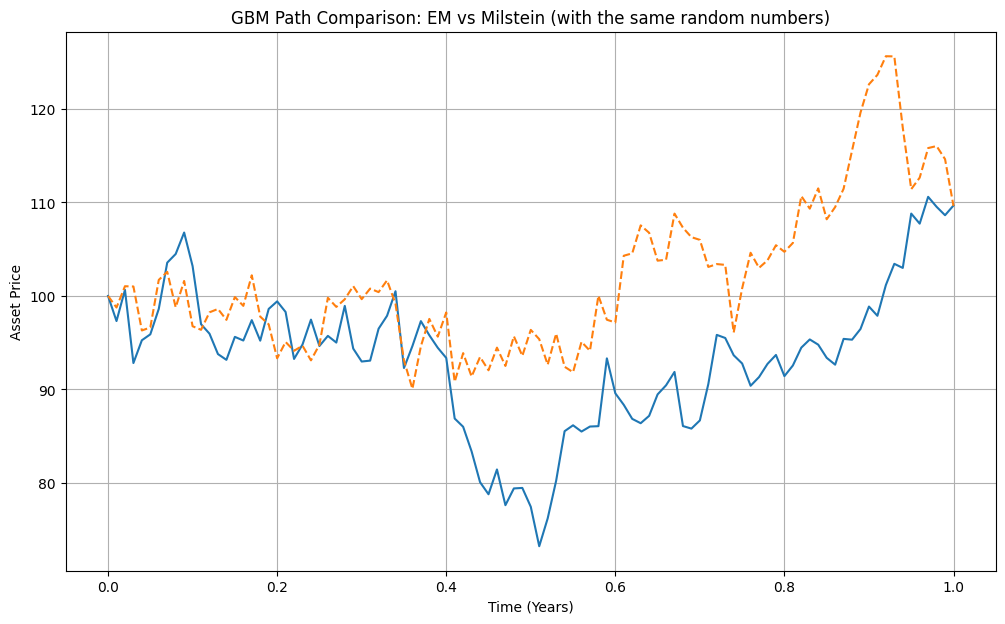

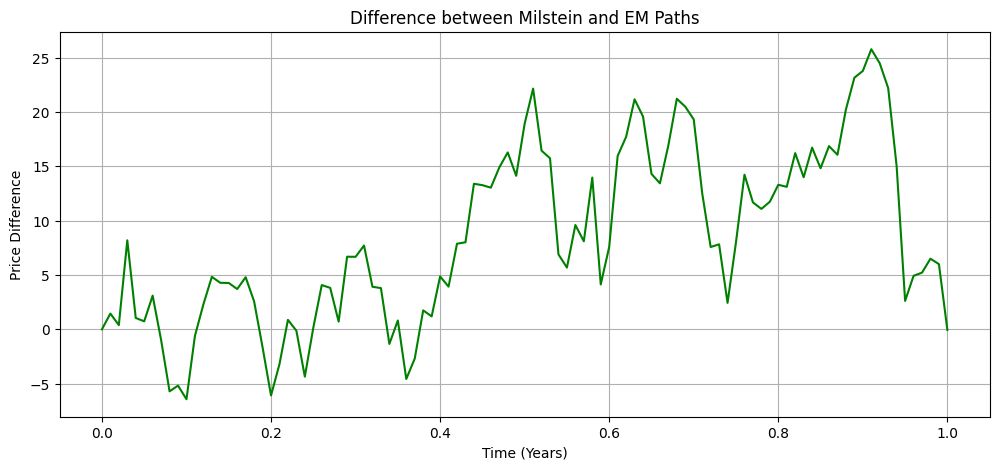

Running for n_steps = 16, dt = 0.06250
Running for n_steps = 32, dt = 0.03125
Running for n_steps = 64, dt = 0.01562
Running for n_steps = 128, dt = 0.00781
Running for n_steps = 256, dt = 0.00391
Running for n_steps = 512, dt = 0.00195


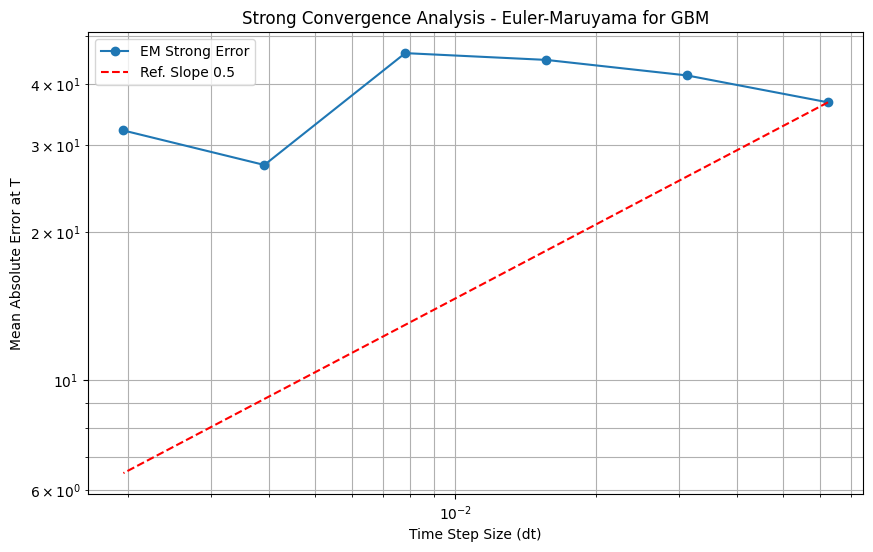

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

#importing simulation functions here (the 2 here bcs we'll compare)

from sde_simulator.simulators import simulate_gbm_em_vectorized, simulate_gbm_milstein_vectorized

S0 = 100      #initial stock price
MU = 0.05     #drift (5% annual return)
SIGMA = 0.3   #volatility (30% annual volatility)
T = 1         #time horizon (1 year)
DT = 0.01     #time step (lower on this notebook to see the difference better)
PATHS = 1     #number of paths (times we repeat the function we did on day 1 basically)


#random numbers (one set only)
N_STEPS = int(T / DT)
Z_shared = np.random.normal(0, 1, size=(N_STEPS, PATHS))

#here, the 2 simulations will have a shared random number (Z)
print("Euler-Maruyama simulation :") ; t_em, S_em = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, DT, PATHS, Z = Z_shared)
print("Milstein simulation :")       ; t_milstein, S_milstein = simulate_gbm_milstein_vectorized(S0, MU, SIGMA, T, DT, PATHS, Z = Z_shared)

plt.figure(figsize=(12, 7))

plt.plot(t_em, S_em[:, 0], label=f'Euler-Maruyama (EM) (dt={DT})', lw=1.5)
plt.plot(t_milstein, S_milstein[:, 0], label=f'Milstein (dt={DT})', lw=1.5, linestyle='--')

plt.title(f'GBM Path Comparison: EM vs Milstein (with the same random numbers)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

#difference plot here
plt.figure(figsize=(12, 5))
plt.plot(t_em, S_milstein[:, 0] - S_em[:, 0], color='green')
plt.title('Difference between Milstein and EM Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()

PATHS = 10 #large number for stable errors estimation

n_steps_range = 2**np.arange(4, 10) #[16, 32, 64, 128, 256, 512]
dt_values_em = np.zeros(len(n_steps_range))
strong_errors_em = np.zeros(len(n_steps_range))

#Loop through the different numbers of steps
for i, n_steps in enumerate(n_steps_range):
    dt = T / n_steps
    dt_values_em[i] = dt
    print(f"Running for n_steps = {n_steps}, dt = {dt:.5f}")

    #random numbers for this dt
    Z = np.random.normal(0, 1, size=(n_steps, PATHS))

    #simulation using EM
    _, S_em = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, dt, PATHS, Z=Z)
    S_T_sim_em = S_em[-1, :]

    #W(T) is the sum of the dW increments used in the simulation
    #dW = Z * sqrt(dt)
    W_T = np.sum(Z * np.sqrt(dt), axis=0) # Sum over time steps (axis 0)
    S_T_exact = S0 * np.exp((MU - 0.5 * SIGMA**2) * T + SIGMA * W_T)

    #mean absolute error
    strong_errors_em[i] = np.mean(np.abs(S_T_sim_em - S_T_exact))
    #strong_errors_em[i] = np.mean((S_T_sim_em - S_T_exact)**2)
    #for debug

plt.figure(figsize=(10, 6))
plt.plot(dt_values_em, strong_errors_em, 'o-', label='EM Strong Error')

#log(error) vs log(dt), we look for a linear relationship with slope gamma
plt.plot(
    dt_values_em, 
    strong_errors_em[0] * (dt_values_em / dt_values_em[0])**0.5,
    'r--', 
    label='Ref. Slope 0.5'
)

"""
plt.plot(
    dt_values_em, 
    strong_errors_em[0] * (dt_values_em / dt_values_em[0])**1.0,
    'k--', 
    label='Ref. Slope 1.0'
)
"""



plt.title('Strong Convergence Analysis - Euler-Maruyama for GBM')
plt.xlabel('Time Step Size (dt)')
plt.ylabel('Mean Absolute Error at T')
plt.xscale('log')
plt.yscale('log') #log-log scale used here to see the power law relationship
plt.grid(True, which='both') #grid on log scale
plt.legend()
plt.show()

We failed today, the error should be following the reference slope, but its not the case here. Did debugging and nothing changed, so it's part of the process :(
So, the simulation/analysis failed to reproduce the theoretical result and we don't know why